# Comparative geometric mean returns

We examine economic and financial time series where Holt-Winters 
is used to forecast one-year ahead. Daily data for bonds, equity, 
and gold is then analyzed.

Our focus is on geometric mean returns since they 
optimally express mean-variance under logarithmic utility. 
We shall cover portfolio optimization in another notebook.

[ ] TODO: *use sympy to symbolically derive geometric mean 
return from the moments of an asset's return distribution.* 
Our function georet() gives a *numerical* approximation. 

*Dependencies:*

- Repository: https://github.com/rsvp/fecon235
- Python: matplotlib, pandas
     
*CHANGE LOG*

    2016-01-05  MAJOR REWRITE: use pattern from monthly and daily series
                   for new functions groupget, grouppc, groupgeoret.
                   Forecast print out replaced by preservable groupholtf.
                   Dictionary comprehension clarifies code.
    2016-01-03  Fix issue #2 with v4 and p6 upgrades.
    2015-05-26  Code revision using template v14.12.21.
    2014-10-11  Code review. Template 2014-09-28.
    2014-09-01  First version.

In [1]:
from fecon235.fecon235 import *

In [2]:
#  PREAMBLE-p6.15.1223 :: Settings and system details
from __future__ import absolute_import, print_function
system.specs()
pwd = system.getpwd()   # present working directory as variable.
print(" ::  $pwd:", pwd)
#  If a module is modified, automatically reload it:
%load_ext autoreload
%autoreload 2
#       Use 0 to disable this feature.

#  Notebook DISPLAY options:
#      Represent pandas DataFrames as text; not HTML representation:
import pandas as pd
pd.set_option( 'display.notebook_repr_html', False )
#  Beware, for MATH display, use %%latex, NOT the following:
#                   from IPython.display import Math
#                   from IPython.display import Latex
from IPython.display import HTML # useful for snippets
#  e.g. HTML('<iframe src=http://en.mobile.wikipedia.org/?useformat=mobile width=700 height=350></iframe>')
from IPython.display import Image 
#  e.g. Image(filename='holt-winters-equations.png', embed=True) # url= also works
from IPython.display import YouTubeVideo
#  e.g. YouTubeVideo('1j_HxD4iLn8', start='43', width=600, height=400)
from IPython.core import page
get_ipython().set_hook('show_in_pager', page.as_hook(page.display_page), 0)
#  Or equivalently in config file: "InteractiveShell.display_page = True", 
#  which will display results in secondary notebook pager frame in a cell.

#  Generate PLOTS inside notebook, "inline" generates static png:
%matplotlib inline   
#          "notebook" argument allows interactive zoom and resize.

 ::  Python 2.7.10
 ::  IPython 4.0.0
 ::  jupyter 1.0.0
 ::  notebook 4.0.6
 ::  matplotlib 1.4.3
 ::  numpy 1.10.1
 ::  pandas 0.17.1
 ::  pandas_datareader 0.2.0
 ::  Repository: fecon235 v4.15.1230 develop
 ::  Timestamp: 2016-01-06, 17:06:06 UTC
 ::  $pwd: /media/yaya/virt15h/virt/dbx/Dropbox/ipy/fecon235/nb


## Download data and construct a dataframe

We retrieve the following data of monthly frequency: **(aggregated) inflation, 
bonds (zero coupon equivalent of 10-y Treasury), equities (S&P 500), and 
gold (London PM fix)** -- all denominated in US dollars -- **then lastly, the 
real trade-weighted USD index (Federal Reserve) and US home prices (per Case-Shiller).** 
The details for each series is given in their respective notebooks. 
If the available data has daily frequency, we use the pandas method called 
"resampling" to induce monthly data (enter "monthly??" in an 
input cell for more details).

ATTENTION: *The inclusion of home prices, unfortunately, will create a 3-month lag, 
due to their release cycle. Since this is a comparative study, 
the rest of the data will appear somewhat stale, but this 
section is intended for long-term trends.* 
Second half of this notebook will examine more responsive daily data.

In [3]:
#  Specify monthly series of interest as a dictionary:
msdic = {'Infl' : m4infl, 'Zero10' : m4zero10, 'SPX' : m4spx, 
         'XAU' : m4xau, 'USD' : m4usdrtb, 'Homes' : m4homepx }

#  Download data into a dataframe:
msdf = groupget( msdic )
#     "groupget??" at input cell gives function details.

 ::  Case-Shiller prepend successfully goes back to 1987.
 ::  S&P 500 prepend successfully goes back to 1957.


After downloading the level series, we compute the YoY percentage change 
for each series. *This will be the a trailing 12-month statistic, 
thus it is overlapping.*

In [4]:
#  Construct the mega YoY dataframe:
mega = grouppc( msdf, freq=12 )

### Define start time and get stats

In [5]:
#  Define start time as t0
t0 = '1988'

#  We can easily rerun the rest of this notebook 
#  by specifying another start time, then: Cell > Run All Below

In [6]:
#  Slice the data:
stats( mega[t0:] )

            Homes        Infl         SPX         USD         XAU      Zero10
count  334.000000  334.000000  334.000000  334.000000  334.000000  334.000000
mean     3.905883    2.397870    8.708560   -0.034278    4.657274    2.247932
std      8.002381    1.015202   16.260123    5.224677   15.495695    7.390370
min    -18.906156   -0.183948  -42.349361  -10.574015  -27.752361  -18.521264
25%     -1.069951    1.678485    2.316010   -3.627323   -6.904147   -3.085161
50%      4.490362    2.349958   10.596906   -0.157484    1.745723    2.892972
75%     10.605588    2.847579   19.535143    2.929578   13.956456    7.705685
max     17.077118    5.243597   52.051354   14.502797   60.357143   20.492399

 ::  Index on min:
Homes    2009-01-01
Infl     2009-07-01
SPX      2009-03-01
USD      2008-03-01
XAU      2013-12-01
Zero10   1994-10-01
dtype: datetime64[ns]

 ::  Index on max:
Homes    2004-07-01
Infl     1990-10-01
SPX      2010-03-01
USD      2009-03-01
XAU      2006-05-01
Zero10   1996-01

There is not much correlation among our assets, 
except a mild negative between gold XAU and USD. 
(2015-05-26 at -0.51)


## Boxplot of overlapping annual changes

The boxplot gives us an idea of the range of annual returns, 
and their persistence due to overlap. Thus trends 
can be easily discerned.

It is also a visual aid for the geometric mean returns 
which is most significant as investment metric. 

As usual, the *red line* plots the median, but 
the **red dot** represents the latest point.

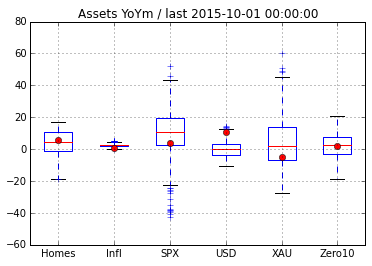

 ::  Finished: boxplot-Assets_YoYm.png


In [7]:
#  Overlapping YoY percentage change, recently:
boxplot(mega[t0:], 'Assets YoYm')
#  where the red dot represents the latest point.

Red dot outside the mid-range box alerts us to unusual conditions. 
Attention should also be paid to the extreme value "slash" marks 
(where outliers are also revealed).


## Geometric mean returns on non-overlapping periods

David E. Shaw, famous for his proprietary hedge fund, remarked that 
one of the most important equations in finance is the penalization 
of arithmetic mean by one-half of variance:

$ g = \mu - (\sigma^2 / 2) $

which turns out to be our geometric mean return. It is an approximation, 
by the way, but good enough to maximize, instead of considering 
intricate mean-variance trade-off. We find it useful also as a metric 
for economic variables.

The source code shows us that georet() first gives us 
the *geometric* mean return, followed by 
the **arithmetic mean return and volatility**, 
then finally, the yearly frequency used -- in list format.

In [8]:
#  How are we computing geometric mean returns?
#  Just add "?" or "??" to variables, procedures, etc.
#  to find out the details, e.g.

georet??

Signature: georet(dfx, yearly=256)
Source:
def georet( dfx, yearly=256 ):
     '''Compute geometric mean return in a summary list.'''
     #  yearly refers to frequency, e.g. 256 for daily trading days,
     #                                    12 for monthly, 
     #                                     4 for quarterly.
     #-alt  dflg = np.log( dfx )
     #-alt  dfpc = dflg.diff( periods=1 )
     dfpc = dfx.pct_change( periods=1 )
     #          ^instead of first difference of logged data,
     #           gives slightly higher arithmetic means.
     mean = dfpc.mean().values.tolist()[0] * yearly
     vari = dfpc.var().values.tolist()[0]  * yearly
     #          ^summary statistics methods, see
     #           McKinney, p.139, Table 5-10.
     geor = mean - (0.5*vari)
     #      ^arithmetic mean return penalized by risk, 
     #      optimal choice under log utility.
     lst = [ geor, mean, vari ** 0.5 ]
     #                        ^^^^^^i.e. std sigma, or volatility.
     lst

In [9]:
#  Geometric mean returns, non-overlapping, annualized:
groupgeoret( msdf[t0:], yearly=12 )
    
#  Note that we applied groupgeoret to msdf, not mega.
#  Generally georet requires price levels.
#  groupgeoret is just georet for group dataframes.

{'Homes': [3.39, 3.42, 2.53, 12],
 'Infl': [2.32, 2.32, 0.5, 12],
 'SPX': [7.58, 8.33, 12.25, 12],
 'USD': [0.19, 0.28, 4.13, 12],
 'XAU': [3.2, 4.05, 13.05, 12],
 'Zero10': [2.07, 2.33, 7.15, 12]}

#### Note: the geometric returns do not include interest and dividend payouts for bonds and equities. Some observations in chronological order:

- 2014-09-01, georet since 2010
    - Inflation at 1.7% which is below Fed target of 2%.
    - Total return on bonds, approx 2.52 + 2.33 = 4.85%
    - Total return on equity, approx. 11.9 + 2 = 13.9% -- very heated.
    - Gold indecisive about breaking 1260 LTS.
    - USD though at -0.69%, will strengthen given Draghi wanting weak EUR.
 
 
 - 2014-10-11, georet since 2004
    - Inflation over ten years is running 2% annually.
    - Gold dominates over ten years.
    - Gold recently holds at 1180 triple local bottom.


 - 2014-10-12, georet since 1988
    - Inflation in the long-run about 3% annually.
    - Bond price alone increases 2% annually (excludes interest income).
    - Gold at 1.73% does not keep up with inflation.
    - USD at break-even over the long-run.
    - Home prices have georet of 3.6%.


- 2015-05-27, georet since 1988
    - Inflation in the long-run drops 70 bp to about 2.3% annually.
    - Bond price continues its increase at 2% annually.
    - Gold at 3.4% reacting more to stronger USD (cf. correlation).
    - Home prices also have georet of 3.4% (but low 2.6% volatility).


- 2016-01-03, georet since 1988
    - Long-run inflation is 2.3% annually (Current Fed target: 2.0%).
    - Bond price increases at 2% annually (but Fed has just hiked rates!).
    - Equities at robust 7.6% annually (but ZIRP is finished).
    - Gold moving along at 2.9% (reflecting horrible 2015 year).
    - Nominal home prices at steady 3.4% per annum. 

# Forecasts using Holt-Winters method

We forecast one-year ahead using the monthly data. 
Note that the most current infl level is rebased to 1, 
thus 1.02 would signify 2% increase.

In [10]:
#  These 12-periods ahead forecasts use default alpha and beta values
#  found to be optimal for a fixed Kalman filter.

groupholtf( msdf, h=12 )

            Homes      Infl          SPX         USD          XAU     Zero10
0   216295.322178  0.999125  2021.400000   97.185000  1165.050000  83.183904
1   216719.918400  0.999473  2067.207192   99.116894  1126.538411  83.140498
2   217393.597328  1.000433  2063.544333   99.945673  1117.644357  83.208857
3   218067.276256  1.001392  2059.881474  100.774452  1108.750303  83.277216
4   218740.955184  1.002352  2056.218615  101.603231  1099.856249  83.345574
5   219414.634112  1.003312  2052.555756  102.432010  1090.962195  83.413933
6   220088.313040  1.004272  2048.892897  103.260789  1082.068141  83.482292
7   220761.991968  1.005232  2045.230038  104.089568  1073.174088  83.550651
8   221435.670896  1.006192  2041.567179  104.918347  1064.280034  83.619010
9   222109.349824  1.007152  2037.904320  105.747125  1055.385980  83.687369
10  222783.028752  1.008112  2034.241461  106.575904  1046.491926  83.755727
11  223456.707680  1.009072  2030.578602  107.404683  1037.597872  83.824086

### Forecast log for monthly data

Changing Holt-Winters *alpha* from 0.20 to 0.10 varies the forecast only slightly. The important parameter is *beta* to capture trend effects. Currently we shall rely on default Holt-Winters settings for robustness.


- 2014-09-01, Twelve-month Forecasts given data through 2014-07-01:
    - Inflation at 1.44%.
    - 10-y Bonds price -6.7%, thus rate +75 bp given zero10dur. 
    - SPX +16.6% to 2280.
    - Gold tanks from 1286 to 1067. 
    - USD +1.4% broadly.


- 2014-10-11, Twelve-month Forecasts given ten-year data, robust HW:
    - Inflation at 1.9%
    - Zero10 indicates slight downward pressure on interest rates.
    - SPX to 2239, but market seems skeptical.
    - Gold tanks to 1184 (region which we have seen just recently).
    - USD definitely has an upward bias against all FX, even NZD and AUD.
    - Home prices looking to increase from \$203K to \$220K 


- 2015-05-28, Twelve-month Forecasts given data through 2015-03-01, robust HW:
    - Inflation at 0.5% (which seems dramatic).
    - Zero10 price increases by 8.92%, thus 10-year rate decreases by 100 bp.
    - SPX to 2322, but no metric says it's fair valued.
    - Gold to 1130, which would break support.
    - USD very strong, up 12% globally (QE-EU started, and possible Grexit).
    - Home prices looking to increase from \$214K to \$223K


- 2016-01-03, Twelve-month Forecasts given data through 2015-10-01, robust HW:
    - Inflation at 1.1% (still below Fed target, see https://git.io/fed)
    - Bonds and equities, forecasting Zero10 and SPX, will be flat.
    - Gold to continue down trend, expected to fall to \$941 in a year.
    - USD 10% higher in light of divergence between Fed hike(s) and ECB QE.
    - Home prices expected to be flat (but watch mortgage spreads).

# DAILY DATA, including major FX

We examine bonds (zero coupon equivalent of 10-y Treasury), 
equities (SPX), gold (XAU), EURUSD, and USDJPY 
at higher frequency (daily) for the most recent developments. 

*Inflation, real trade-weighted USD index, and US home price data 
have a slow monthly release schedule. 
And for home price data, there is a three month lag.* 

In [11]:
#  Specify daily series of interest as a dictionary
#  where key is name, and value is its data code:
dsdic = { 'Zero10' : d4zero10, 'SPX' : d4spx, 'XAU' : d4xau, 
          'EURUSD' : d4eurusd, 'USDJPY' : d4usdjpy }

In [12]:
#  Download data into a dataframe:
dsdf = groupget( dsdic )

 ::  S&P 500 prepend successfully goes back to 1957.


In [13]:
#  Construct the dega YoY percent dataframe:
dega = grouppc( dsdf, freq=256 )
#                         ^for daily data

In [14]:
#  Set the start date for daily series:
u0 = '2010-01-01'

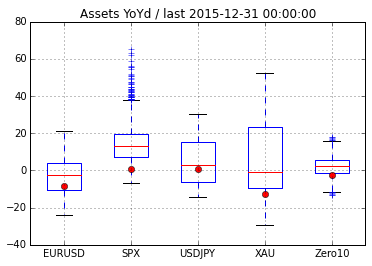

 ::  Finished: boxplot-Assets_YoYd.png


In [15]:
#  Plot overlapping percentage changes:
boxplot( dega[u0:], 'Assets YoYd' )

#  Note that the "last" timestamp will be more
#  recent than for the monthly series.

Although monthly data is more suitable for making long-term forecasts, 
daily data is much more sensitive to immediate market perturbations. 

2016-01-03  Good example of the foregoing remark is the 
reaction in the overall market due to the first Fed rate hike 
in almost a decade on 2015-12-16. ZIRP, zero interest rate program, 
has been terminated, along with US quantitative easing, 
thus asset prices must adjust to financing constraints. 
Note how equities and gold are now below their mid-range boxes.

In [16]:
stats(dega[u0:])

            EURUSD          SPX       USDJPY          XAU       Zero10
count  1565.000000  1565.000000  1565.000000  1565.000000  1565.000000
mean     -3.239333    14.108931     4.967449     4.568358     1.861880
std       9.126193    10.118387    11.876045    18.700101     6.470399
min     -23.984762    -6.776581   -14.310589   -29.210332   -13.248728
25%     -10.613876     7.172626    -6.285016    -9.629768    -1.231181
50%      -2.304728    13.200272     2.984473    -0.627657     2.419923
75%       3.984704    19.505195    15.422171    23.593619     5.626088
max      21.056554    65.300874    30.357599    52.361809    18.075299

 ::  Index on min:
EURUSD   2015-03-11
SPX      2015-08-25
USDJPY   2011-03-17
XAU      2013-12-26
Zero10   2010-01-07
dtype: datetime64[ns]

 ::  Index on max:
EURUSD   2011-06-06
SPX      2010-03-02
USDJPY   2013-05-28
XAU      2011-09-06
Zero10   2012-02-01
dtype: datetime64[ns]

 ::  Head:
              EURUSD        SPX    USDJPY        XAU     Zero10
T

- 2015-05-29, Suprisingly, very little correlation between EURUSD and USDJPY: -6%. Gold appears more correlated with USDJPY at -87% than EURUSD at +6%

- 2016-01-05, Given the latest Fed hike, the correlation to watch is between equities and bonds (-0.69 SPX and Zero10).

In [17]:
#  What are the latest daily prices?
tail( dsdf )

            EURUSD      SPX  USDJPY      XAU     Zero10
T                                                      
2015-12-23  1.0875  2064.29  120.94  1068.25  81.685673
2015-12-24  1.0955  2060.99  120.32  1068.25  81.830579
2015-12-25  1.0955  2060.99  120.32  1068.25  81.830579
2015-12-28  1.0983  2056.50  120.30  1068.25  81.903134
2015-12-29  1.0916  2078.36  120.44  1070.10  81.324593
2015-12-30  1.0912  2063.36  120.60  1060.00  81.396674
2015-12-31  1.0859  2043.94  120.27  1060.00  81.685673

In [18]:
#  Geometric mean returns, non-overlapping, annualized:
groupgeoret( dsdf[u0:], yearly=256 )

{'EURUSD': [-4.54, -4.08, 9.64, 256],
 'SPX': [9.92, 11.16, 15.76, 256],
 'USDJPY': [4.19, 4.63, 9.3, 256],
 'XAU': [-0.41, 1.08, 17.27, 256],
 'Zero10': [2.28, 2.56, 7.48, 256]}

### Closing remarks on daily data

- 2014-10-11, Really near-term picture is too bright for SPX while XAU looks dark. Sell stocks, and start to accumulate gold.


- 2015-05-28, XAU georet changed from 2.6% to 1.6%. Zero10 monthly forecast is basically unchanged. Real rate is what matters for gold. USD stronger by 4.8% against both the EUR and JPY.


- 2016-01-03, XAU georet changed from 1.6% to -0.41%, commodities including oil going through a bear market. Bonds have not sold off despite 2015-12-16 Fed rate hike, probably due to world appetite for USD which is stronger by about 4.3% against EUR and JPY. SPX looks vulnerable given the past maxims about rate hikes, but the Fed is actually still very accomodative.

[ ] TODO: notebook on r\* the so-called natural interest rate.